In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from scipy.stats import describe
import seaborn as sns
from pylab import rcParams

pd.options.display.max_columns = 12
pd.options.display.max_rows = 24

# disable warnings in Anaconda
warnings.simplefilter('ignore')

# plots inisde jupyter notebook
%matplotlib inline

sns.set(style='darkgrid', palette='muted')
color_scheme = {
    'red': '#F1637A',
    'green': '#6ABB3E',
    'blue': '#3D8DEA',
    'black': '#000000'
}

# use svg for all plots within inline backend
%config InlineBackend.figure_format = 'svg'

# increase default plot size
rcParams['figure.figsize'] = 8, 6

# loadding data

In [2]:

all_data = pd.read_csv('sales所在周次节假日_剔除换货.csv')
all_data.rename(columns={'店铺名称':'store','地理位置指数':'position','年份':'years','周次':'weeks of year','是否包含法定节假日':'Isholiday','季节':'season','大类':'item','销量(剔除换货）':'sales','均价（剔除换货）':'prices','促销（剔除换货）':'discount'},inplace=True)
all_data['weeks'] = all_data['weeks of year']

a = all_data
week_5 = a.loc[lambda a : a['years'] == 2015]
week_6 = a.loc[lambda a : a['years'] == 2016]
week_6['weeks'] += 53
a = pd.concat([week_5,week_6])

from sklearn import preprocessing

#map店铺名称
name = a['store']
le = preprocessing.LabelEncoder()
le.fit(name)
list(name)
le.transform(name)
tmp = le.transform(name)
a['store'] = tmp

#map合并大类
category = a['item']
le.fit(category)
list(category)
le.transform(category)
tmp = le.transform(category)
a['item'] = tmp

#map季节
season = a['season']
le.fit(season)
list(season)
le.transform(season)
tmp = le.transform(season)
a['season'] = tmp



In [3]:
df_n = a
#df_n['sales'] = np.log1p(df_n.sales.values)
df_n['prices'] = np.log1p(df_n.sales.values)
df_n.sample(2)

,store,position,years,weeks of year,Isholiday,season,item,sales,prices,discount,weeks
3937,6,1,2016,6,1,2,6,6,1.945910,0.405344,59
11207,18,1,2015,46,0,0,9,3,1.386294,0.483034,46


In [4]:
a = pd.DataFrame(df_n.groupby(['store','weeks','item']).sum()['sales']).unstack()
#检验缺失值
for i in df_n['store'].drop_duplicates():
    a = df_n[lambda df_n : df_n['store'] == i]
    b = a['weeks'].drop_duplicates().count()
    print (i,b)

#删除缺失值
for i in df_n['store'].drop_duplicates():
    a = df_n[lambda df_n : df_n['store'] == i]
    b = a['weeks'].drop_duplicates().count()
    #print (i,b)
    if b != 106:
        s_ = df_n[lambda df_n: df_n['store'] == i]
        index_s = s_.index
        df_n = df_n.drop(index_s)
        
for i in df_n['store'].drop_duplicates():
    a = df_n[lambda df_n : df_n['store'] == i]
    b = a['weeks'].drop_duplicates().count()
    print (i,b)

0 106
2 106
3 106
4 106
5 106
6 106
7 106
8 106
9 106
10 106
11 106
12 106
13 79
14 106
16 106
17 106
18 106
19 106
21 106
22 106
23 106
24 106
25 106
26 92
27 106
28 106
29 106
1 17
15 17
20 29
0 106
2 106
3 106
4 106
5 106
6 106
7 106
8 106
9 106
10 106
11 106
12 106
14 106
16 106
17 106
18 106
19 106
21 106
22 106
23 106
24 106
25 106
27 106
28 106
29 106


In [5]:
a_p = df_n
a_p_sale = pd.DataFrame(a_p.groupby(['weeks','store','item']).sum()['sales']).unstack()
a_p_s = a_p_sale.fillna(0).stack()
a_p_s_i = a_p_s.reset_index(['store','item'])
#a_p_s_i
index_s = a_p_s_i['store'] .drop_duplicates().values

#a_p_s_i

#重新映射store
name = a_p_s_i['store']
le = preprocessing.LabelEncoder()
le.fit(name)
list(name)
le.transform(name)
tmp = le.transform(name)
a_p_s_i['store'] = tmp

In [6]:
df_train = a_p_s_i[0:24600]
df_test = a_p_s_i[24600:31801]

In [7]:
from itertools import product, starmap


def storeitems():
    return product(range(0,12),range(0,25))


def storeitems_column_names():
    return list(starmap(lambda i,s: f'item_{i}_store_{s}_sales', storeitems()))


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique())
    for i, s in storeitems():
        ret[f'item_{i}_store_{s}_sales'] = df[(df['item'] == i) & (df['store'] == s)]['sales'].values
    return ret

In [8]:
df_train = sales_by_storeitem(df_train)
# for test set, we just fill y values with zeros (they won't be used anyway)
df_test['sales'] = np.zeros(df_test.shape[0])
df_test = sales_by_storeitem(df_test)

In [9]:
# make sure all column names are the same and in the same order
col_names = list(zip(df_test.columns, df_train.columns))
for cn in col_names:
    assert cn[0] == cn[1]

In [10]:
df_test['is_test'] = np.repeat(True, df_test.shape[0])
df_train['is_test'] = np.repeat(False, df_train.shape[0])
df_total = pd.concat([df_train, df_test])

In [11]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0,1))
#cols_to_scale = [col for col in df_total.columns if 'weekday' not in col and 'month' not in col]
#scaled_cols = scaler.fit_transform(df_total[cols_to_scale])
#df_total[cols_to_scale] = scaled_cols

#将数据集分为训练集和测试集
df_train = df_total[df_total['is_test'] == False].drop('is_test', axis=1)
df_test = df_total[df_total['is_test'] == True].drop('is_test', axis=1)

In [12]:
week_df = pd.get_dummies(df_total.index,'weeks of year')
week_df.index += 1
df_total_w = pd.concat([week_df,df_total],axis=1)


In [13]:
df_total_w = df_total_w.drop(['is_test'],axis=1)
df_total_w

,weeks of year_1,weeks of year_2,weeks of year_3,weeks of year_4,weeks of year_5,weeks of year_6,...,item_11_store_19_sales,item_11_store_20_sales,item_11_store_21_sales,item_11_store_22_sales,item_11_store_23_sales,item_11_store_24_sales
1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0
9,0,0,0,0,0,0,...,4.0,2.0,0.0,1.0,1.0,4.0
10,0,0,0,0,0,0,...,1.0,2.0,1.0,1.0,3.0,23.0


# training model

In [14]:
'''
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col or 'year' in col]
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]

X_colset = set(X_cols)
y_cols = [col for col in df_train.columns if col not in X_colset]

y = df_train[y_cols]
'''
y_cols = df_total[54:106]

X = df_total_w[0:53]
y = df_total[0:53]


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, shuffle=False)

X_valid, y_valid = X_valid.head(90), y_valid.head(90)

X_train_vals = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_valid_vals = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

In [15]:
X_train

,weeks of year_1,weeks of year_2,weeks of year_3,weeks of year_4,weeks of year_5,weeks of year_6,...,item_11_store_19_sales,item_11_store_20_sales,item_11_store_21_sales,item_11_store_22_sales,item_11_store_23_sales,item_11_store_24_sales
1,1,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
3,0,0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
5,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0
6,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0
7,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0
9,0,0,0,0,0,0,...,4.0,2.0,0.0,1.0,1.0,4.0
10,0,0,0,0,0,0,...,1.0,2.0,1.0,1.0,3.0,23.0


In [16]:
X_train_vals.shape

(42, 1, 406)

In [17]:
X_valid_vals.shape

(11, 1, 406)

In [18]:
#定义模型

from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Conv1D, Input, Dropout, AvgPool1D, Reshape, Concatenate

basic_model = Sequential()
basic_model.add(LSTM(301, input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])))
basic_model.add(Dense(301))
basic_model.compile(loss='mean_absolute_error', optimizer='adam')

inputs = Input(shape=(X_train_vals.shape[1], X_train_vals.shape[2]))
# top pipeline
top_lstm = LSTM(301)(inputs)
top_dense = Dense(301, activation='relu')(top_lstm)
top_dropout = Dropout(301)(top_dense)
# bottom pipeline
bottom_dense = Dense(301)(inputs)
bottom_conv1 = Conv1D(
    301, 
    kernel_size=1,
    input_shape=(X_train_vals.shape[1], X_train_vals.shape[2])
)(bottom_dense)
bottom_conv2 = Conv1D(
    3010,
    kernel_size=50,
    padding='same',
    activation='relu'
)(bottom_conv1)
bottom_conv3 = Conv1D(
    301,
    kernel_size=10,
    padding='same',
    activation='relu'
)(bottom_conv2)
bottom_pooling = AvgPool1D(
    pool_size=60, 
    padding='same'
)(bottom_conv3)
bottom_reshape = Reshape(
    target_shape=[301]
)(bottom_conv3)
# concat output from both pipelines
final_concat = Concatenate()([top_dropout, bottom_reshape])
final_dense = Dense(301)(final_concat)
# compile and return
complex_model = Model(inputs=inputs, outputs=final_dense)
complex_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mape'])

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [19]:
#简单网络

basic_history = basic_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=60, 
    batch_size=30,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Instructions for updating:
Use tf.cast instead.
Train on 42 samples, validate on 11 samples
Epoch 1/60
 - 5s - loss: 4.1565 - val_loss: 4.6198
Epoch 2/60
 - 0s - loss: 4.0861 - val_loss: 4.5963
Epoch 3/60
 - 0s - loss: 4.0415 - val_loss: 4.5800
Epoch 4/60
 - 0s - loss: 4.0054 - val_loss: 4.5684
Epoch 5/60
 - 0s - loss: 3.9693 - val_loss: 4.5587
Epoch 6/60
 - 0s - loss: 3.9301 - val_loss: 4.5512
Epoch 7/60
 - 0s - loss: 3.8907 - val_loss: 4.5444
Epoch 8/60
 - 0s - loss: 3.8493 - val_loss: 4.5392
Epoch 9/60
 - 0s - loss: 3.8062 - val_loss: 4.5332
Epoch 10/60
 - 0s - loss: 3.7619 - val_loss: 4.5247
Epoch 11/60
 - 0s - loss: 3.7180 - val_loss: 4.5139
Epoch 12/60
 - 0s - loss: 3.6737 - val_loss: 4.5000
Epoch 13/60
 - 0s - loss: 3.6292 - val_loss: 4.4819
Epoch 14/60
 - 0s - loss: 3.5850 - val_loss: 4.4587
Epoch 15/60
 - 0s - loss: 3.5396 - val_loss: 4.4334
Epoch 16/60
 - 0s - loss: 3.4968 - val_loss: 4.4060
Epoch 17/60
 - 0s - loss: 3.4541 - val_loss: 4.3771
Epoch 18/60
 - 0s - loss: 3.4122 

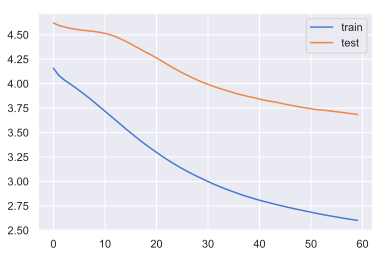

In [20]:
#绘图

def plot_history(history):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show()
    
plot_history(basic_history)

In [21]:
#复杂网络

complex_history = complex_model.fit(
    X_train_vals, 
    y_train.values, 
    epochs=130, 
    batch_size=70,
    validation_data=(X_valid_vals, y_valid.values),
    verbose=2,
    shuffle=False
)

Train on 42 samples, validate on 11 samples
Epoch 1/130
 - 14s - loss: 289.8177 - mean_absolute_percentage_error: 107877136.0000 - val_loss: 241.0701 - val_mean_absolute_percentage_error: 423530208.0000
Epoch 2/130
 - 6s - loss: 272.1411 - mean_absolute_percentage_error: 403826432.0000 - val_loss: 215.6283 - val_mean_absolute_percentage_error: 1430893824.0000
Epoch 3/130
 - 6s - loss: 235.1613 - mean_absolute_percentage_error: 1272084480.0000 - val_loss: 209.4491 - val_mean_absolute_percentage_error: 3798280448.0000
Epoch 4/130
 - 6s - loss: 222.7235 - mean_absolute_percentage_error: 3146522112.0000 - val_loss: 179.3996 - val_mean_absolute_percentage_error: 2589490432.0000
Epoch 5/130
 - 6s - loss: 177.2567 - mean_absolute_percentage_error: 2355424256.0000 - val_loss: 173.0345 - val_mean_absolute_percentage_error: 2259368704.0000
Epoch 6/130
 - 6s - loss: 156.2681 - mean_absolute_percentage_error: 2160188160.0000 - val_loss: 168.3581 - val_mean_absolute_percentage_error: 2252638464.000

Epoch 53/130
 - 6s - loss: 7.9836 - mean_absolute_percentage_error: 830801344.0000 - val_loss: 93.8046 - val_mean_absolute_percentage_error: 1263446656.0000
Epoch 54/130
 - 6s - loss: 7.6308 - mean_absolute_percentage_error: 817002048.0000 - val_loss: 93.4355 - val_mean_absolute_percentage_error: 1260361600.0000
Epoch 55/130
 - 6s - loss: 7.2873 - mean_absolute_percentage_error: 803219264.0000 - val_loss: 93.1406 - val_mean_absolute_percentage_error: 1258575488.0000
Epoch 56/130
 - 6s - loss: 6.9589 - mean_absolute_percentage_error: 787429760.0000 - val_loss: 92.8498 - val_mean_absolute_percentage_error: 1255706624.0000
Epoch 57/130
 - 6s - loss: 6.6418 - mean_absolute_percentage_error: 772245888.0000 - val_loss: 92.4858 - val_mean_absolute_percentage_error: 1251750528.0000
Epoch 58/130
 - 6s - loss: 6.3451 - mean_absolute_percentage_error: 757181312.0000 - val_loss: 92.0975 - val_mean_absolute_percentage_error: 1246172672.0000
Epoch 59/130
 - 6s - loss: 6.0633 - mean_absolute_percenta

Epoch 106/130
 - 6s - loss: 0.8011 - mean_absolute_percentage_error: 302876512.0000 - val_loss: 87.5636 - val_mean_absolute_percentage_error: 1198553728.0000
Epoch 107/130
 - 6s - loss: 0.7687 - mean_absolute_percentage_error: 297243616.0000 - val_loss: 87.5605 - val_mean_absolute_percentage_error: 1198893952.0000
Epoch 108/130
 - 6s - loss: 0.7377 - mean_absolute_percentage_error: 291753984.0000 - val_loss: 87.5438 - val_mean_absolute_percentage_error: 1198670464.0000
Epoch 109/130
 - 6s - loss: 0.7078 - mean_absolute_percentage_error: 286217792.0000 - val_loss: 87.5045 - val_mean_absolute_percentage_error: 1198419456.0000
Epoch 110/130
 - 6s - loss: 0.6792 - mean_absolute_percentage_error: 280604288.0000 - val_loss: 87.4845 - val_mean_absolute_percentage_error: 1198376192.0000
Epoch 111/130
 - 6s - loss: 0.6516 - mean_absolute_percentage_error: 275198464.0000 - val_loss: 87.4849 - val_mean_absolute_percentage_error: 1198354432.0000
Epoch 112/130
 - 7s - loss: 0.6253 - mean_absolute_p

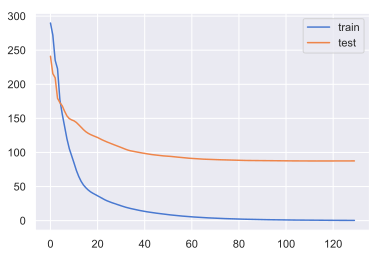

In [22]:
#绘图

plot_history(complex_history)

# 评价模型

In [23]:
def model_eval(model, X_test, y_test):
    """
    Evaluate (step-by-step) model predictions from X_test and return predictions and real values in comparable format.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols]
    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols]
    n_samples = y_test.shape[0]
    y_pred = np.zeros(y_test.shape)
    # iterate
    x_next = X_test.iloc[0].values
    for i in range(0, n_samples):
        x_arr = np.array([x_next])
        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        y_pred[i] = model.predict(x_arr)[0] # input for prediction must be 2d, output is immediately extracted from 2d to 1d
        try:
            x_next = X_test.iloc[i+1].values
            x_next[sales_x_idxs] = y_pred[i][sales_y_idxs]
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values


def unscale(y_arr, scaler, template_df, toint=False):
    """
    Unscale array y_arr of model predictions, based on a scaler fitted 
    to template_df.
    """
    tmp = template_df.copy()
    tmp[y_cols] = pd.DataFrame(y_arr, index=tmp.index)
    tmp[cols_to_scale] = scaler.inverse_transform(tmp[cols_to_scale])
    if toint:
        return tmp[y_cols].astype(int)
    return tmp[y_cols]


def vector_smape(y_pred, y_real):
    nom = np.abs(y_pred-y_real)
    denom = (np.abs(y_pred) + np.abs(y_real)) / 2
    results = nom / denom
    return 100*np.mean(results)  # in percent, same as at kaggle

In [24]:
y_pred_basic, y_real = model_eval(basic_model, X_valid, y_valid)

y_pred_complex = model_eval(complex_model, X_valid, y_valid)[0]

# this is just for unscaling
template_df = pd.concat([X_valid, y_valid], axis=1)
template_df['is_test'] = np.repeat(True, template_df.shape[0])

basic_pred = unscale(y_pred_basic, scaler, template_df, toint=True)
complex_pred = unscale(y_pred_complex, scaler, template_df, toint=True)
real = unscale(y_real, scaler, template_df, toint=True)

basic_smapes = [vector_smape(basic_pred[col], real[col]) for col in basic_pred.columns]
complex_smapes = [vector_smape(complex_pred[col], real[col]) for col in complex_pred.columns]

TypeError: Must pass DataFrame or 2-d ndarray with boolean values only

In [ ]:
#绘图

sns.distplot(basic_smapes, label='Basic model')
sns.distplot(complex_smapes, label='Complex model')
plt.legend(loc='upper right')
plt.savefig('smape_basic_vs_complex.svg')
plt.show()

In [ ]:
describe(basic_smapes)

In [ ]:
describe(complex_smapes)

# 可视化结果

In [ ]:
store, item = 1,1
plot_lengths = [7, 30, 90]
rolling_mean_windows = [1, 1, 2]  # to make plots more readable

In [ ]:
storeitem_col = f'item_{item}_store_{store}_sales'

for pl, mw in zip(plot_lengths, rolling_mean_windows):
    plt.plot(basic_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['blue'],
             lw=2,
             label='Basic model prediction')
    plt.plot(complex_pred[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['green'],
             lw=2, 
             label='Complex model prediction')
    plt.plot(real[storeitem_col].rolling(mw).mean().values[:pl],
             color_scheme['black'],
             lw=2, 
             label='Real values')
    plt.legend(loc='upper left')
    plt.savefig(f'plot_prediction_{pl}_{mw}.svg')
    plt.show()